In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
import os
import scipy.signal

from htr import page_detection
from htr import word_detection

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)


def implt(img, cmp=None, t=''):
    plt.imshow(img, cmap=cmp)
    plt.title(t)
    plt.show()

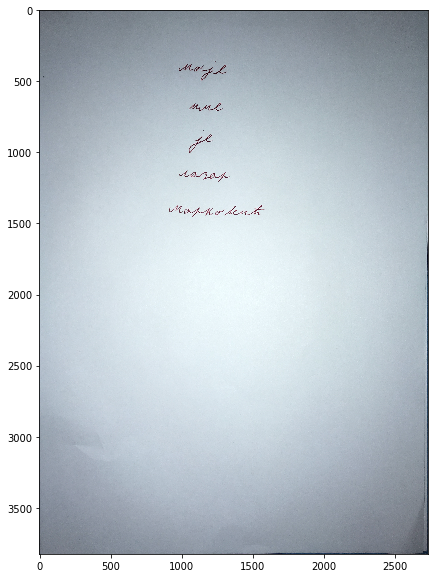

In [3]:
path = "./data/my-pages/t1.jpg"
image = page_detection.detect(path)
implt(image)

word_imgs = word_detection.detect(image)

#for w in word_imgs:
#    implt(w)

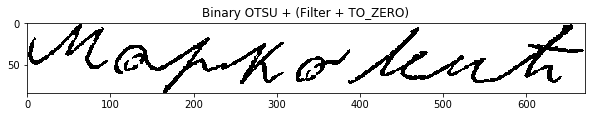

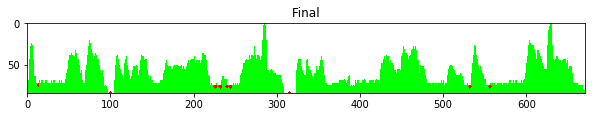

svee:  [  0  13 100 226 232 240 244 315 532 556 670]
SS:  13
SS:  100
W: 100
H: 84
B: 0


SS:  126
W: 126
H: 84
B: 100


SS:  6
SS:  14
SS:  18
SS:  89
W: 89
H: 84
B: 226


SS:  217
W: 217
H: 84
B: 315


SS:  24
SS:  138
W: 138
H: 84
B: 532




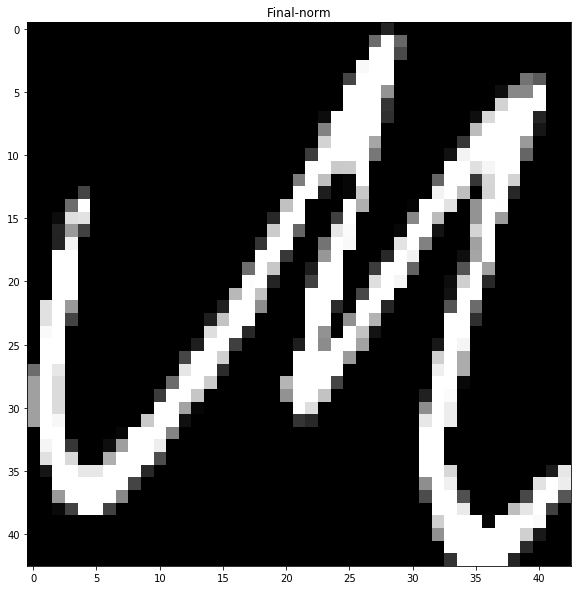

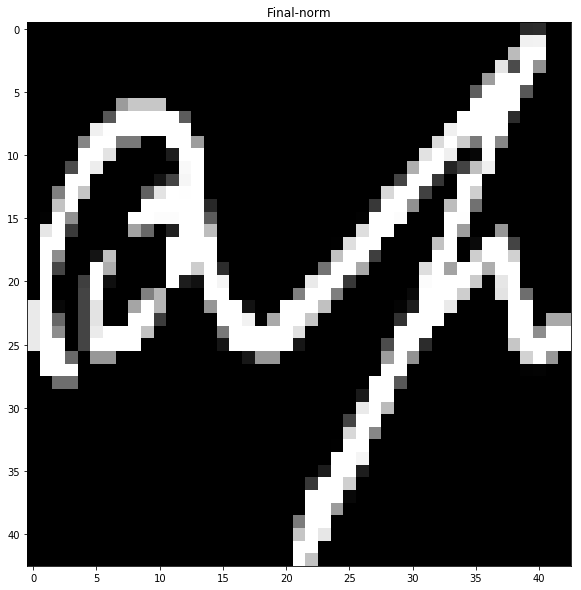

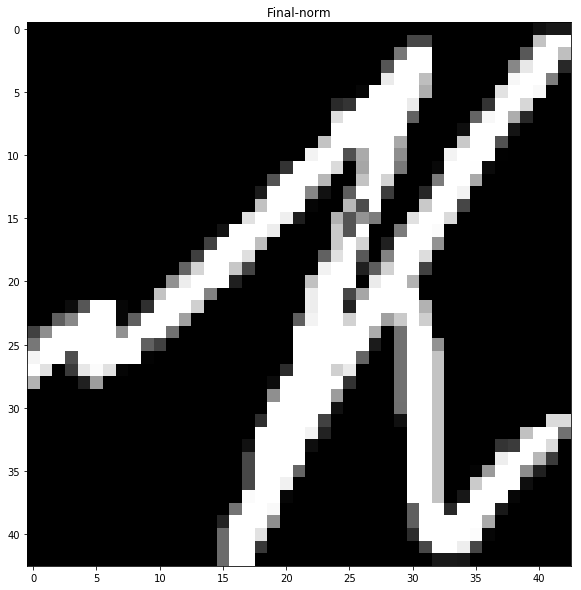

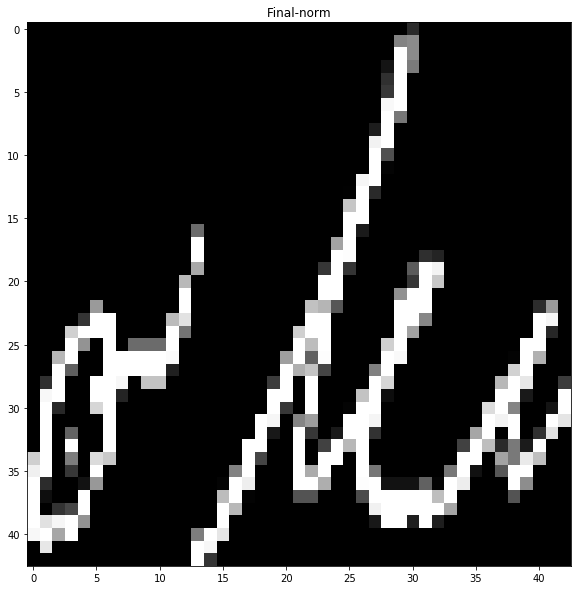

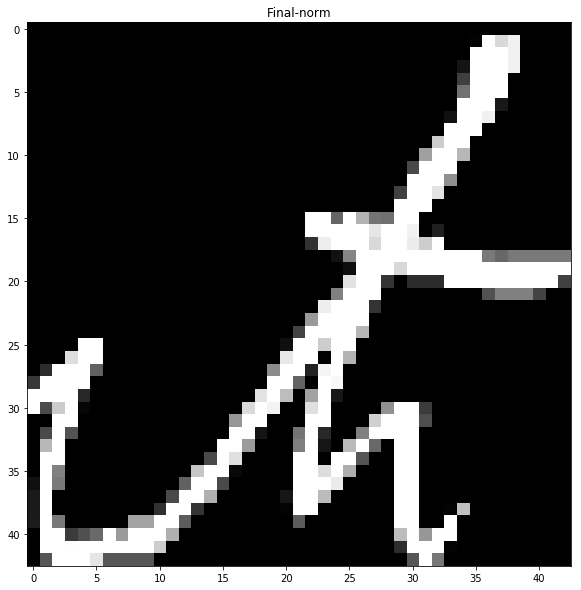

In [41]:
img_copy = word_imgs[4].copy()

img = cv2.cvtColor(img_copy, cv2.COLOR_RGB2GRAY)

thresh = 255-histogram_norm(img)
thresh = cropp(thresh)
implt(thresh, 'gray', 'Binary OTSU + (Filter + TO_ZERO)')


hist = vertical_projection(thresh)
hist = (hist - np.amin(hist))/(np.amax(hist) - np.amin(hist))

h, w = thresh.shape
indexes = scipy.signal.find_peaks((np.array(hist))*h, prominence=40, width=1)

RGBmask = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8) + 255
count=0
for l in hist:
    cv2.line(RGBmask, (count, int(h*(l))), (count, h), color=[0,255,0], thickness=1)
    count += 1

for i in indexes[0]:
    cv2.circle(RGBmask, (i, int(h*hist[i])), radius=2, color=[255,0,0], thickness=-1) 
    #cv2.line(RGBmask, (i, 0), (i, h), color=[255,0,0], thickness=1)

implt(RGBmask, cmp='gray', t='Final')

r = segment2(thresh, h, w, indexes[0])

norm = []
for rr in r:
    cropped = cropp(rr)
    resized = cv2.resize(255-cropped,(43,43))
    norm.append(resized)
    implt(resized, cmp='gray', t='Final-norm')

In [35]:
def segment(img, height, width, indexes):
    rois = []
    indexes = np.insert(indexes, 0, 0)
    indexes = np.insert(indexes, len(indexes), width-1)
    print("svee: ", indexes)
    for i in range(len(indexes)-1):
        width = indexes[i+1] - indexes[i]
        if width < 40:
            continue
        print('W:', width)
        print('H:', height)
        print('B:', indexes[i])
        print('\n')
        roi = img[0:height, indexes[i]:indexes[i]+width]
        rois.append(roi)
    return rois
        
    
def segment2(img, height, width, indexes):
    rois = []
    indexes = np.insert(indexes, 0, 0)
    indexes = np.insert(indexes, len(indexes), width-1)
    print("svee: ", indexes)
    
    first = 0
    second = 1
    while (first < len(indexes)) and (second < len(indexes)):
        width = indexes[second] - indexes[first]
        print("SS: ", width)
        if width < 30:
            second += 1
            continue
        print('W:', width)
        print('H:', height)
        print('B:', indexes[first])
        print('\n')
        roi = img[0:height, indexes[first]:indexes[first]+width]
        rois.append(roi)
        first = second
        second += 1
    return rois
        

In [5]:
def vertical_projection(img):
    (h, w) = img.shape[:2]
    sumCols = []
    for j in range(w):
        col = img[0:h, j:j+1] # y1:y2, x1:x2
        sumCols.append(np.sum(col)/255)
    return sumCols

In [6]:
def histogram_norm(img):
    img = bilateral_norm(img)
    add_img = 255 - cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    img = 255 - img
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255        
    hist, bins = np.histogram(img.ravel(), 256, [0,256])
    
    img = img.astype(np.uint8)

    ret,thresh4 = cv2.threshold(img,np.argmax(hist)+10,255,cv2.THRESH_TOZERO)
    return add_img
    return cv2.add(add_img, thresh4, dtype=cv2.CV_8UC1)

def bilateral_norm(img):
    img = cv2.bilateralFilter(img, 9, 15, 30)
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

def cropp(img):
    h,w = img.shape
    top=0
    down=0
    left=0
    right=0
    
    halt = False
    for i in range(h):
        if halt:
            break
        for j in range(w):
            if img[i,j] == 0:
                halt = True
                top = i-1
                break
                
    halt = False
    for i in reversed(range(h)):
        if halt:
            break
        for j in range(w):
            if img[i,j] == 0:
                halt = True
                down = i+1
                break
    
    halt = False
    for i in range(w):
        if halt:
            break
        for j in range(h):
            if img[j,i] == 0:
                halt = True
                left = i-1
                break
                
    halt = False
    for i in reversed(range(w)):
        if halt:
            break
        for j in range(h):
            if img[j,i] == 0:
                halt = True
                right = i+1
                break
                
    if (top < 0): top = 0
    if (down < 0): down = 0
    if (left < 0): left = 0
    if (right < 0): right = 0
        
    #print('Top: ', top)
    #print('Down: ', down)
    #print('Left: ', left)
    #print('Right: ', right)
    
    return img[top:down, left:right]